# Integrated Fear & Greed ML Pipeline

This notebook integrates the feature store setup and comprehensive AutoML experiments for the Fear & Greed classification and regression tasks.

## Overview
- **Feature Versions**: v1 (returns), v2 (returns + MA), v3 (returns + MA + ratios)  
- **Tasks**: Classification (Market Sentiment) & Regression (VIX Prediction)
- **Models**: Traditional ML + AutoML (FLAML)
- **Approach**: Feature Store → AutoML → Comprehensive Analysis

## Setup and Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
from datetime import datetime
import sys
import joblib
from typing import Dict, List, Tuple, Optional

# Suppress warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Project paths
project_root = Path.cwd()  # Already in Market-Fear-Greed-Indicator directory
data_dir = project_root / "data"
feature_store_dir = project_root / "feature_store"
models_dir = project_root / "models"
results_dir = project_root / "results"

# Create directories
for dir_path in [data_dir, feature_store_dir, models_dir, results_dir]:
    dir_path.mkdir(exist_ok=True)

print(f"Project root: {project_root}")
print(f"Data directory: {data_dir}")
print(f"Feature store: {feature_store_dir}")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

## Import Feature Store and AutoML Classes

In [ ]:
# Add Market-Fear-Greed-Indicator to path for imports
sys.path.append(str(project_root))

try:
    from feature_store_setup import FearGreedFeatureStore
    print("✅ FearGreedFeatureStore imported successfully")
    FEATURE_STORE_AVAILABLE = True
except ImportError as e:
    print(f"⚠️ Could not import FearGreedFeatureStore: {e}")
    FEATURE_STORE_AVAILABLE = False

try:
    from automl_integration import FearGreedAutoML
    print("✅ FearGreedAutoML imported successfully")
    AUTOML_AVAILABLE = True
except ImportError as e:
    print(f"⚠️ Could not import FearGreedAutoML: {e}")
    AUTOML_AVAILABLE = False

# Check for external AutoML libraries
try:
    import flaml
    print("✅ FLAML available")
    FLAML_AVAILABLE = True
except ImportError:
    print("⚠️ FLAML not available (pip install flaml for enhanced AutoML)")
    FLAML_AVAILABLE = False

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.neural_network import MLPClassifier, MLPRegressor

print("\n✅ All ML libraries imported successfully")

## Data Loading and Feature Store Setup

In [3]:
# Check if feature pipeline data already exists
feature_summary_file = feature_store_dir / "feature_pipeline_summary.json"

if feature_summary_file.exists():
    print("📁 Loading existing feature pipeline data...")
    with open(feature_summary_file, 'r') as f:
        feature_summary = json.load(f)
    
    print("Available Feature Versions:")
    print("=" * 50)
    for version, info in feature_summary.items():
        print(f"{version}: {info['num_features']} features")
        print(f"  Local file: {info['local_name']}.parquet")
        print(f"  Sample features: {', '.join(info['features'][:5])}{'...' if len(info['features']) > 5 else ''}")
        print()
        
    FEATURES_READY = True
    
else:
    print("🔧 Feature data not found. Setting up feature store...")
    
    if not FEATURE_STORE_AVAILABLE:
        print("❌ Feature store class not available. Please check imports.")
        FEATURES_READY = False
    else:
        # Initialize and run feature store setup
        fs = FearGreedFeatureStore(data_dir=str(data_dir), feature_store_dir=str(feature_store_dir))
        
        try:
            # Load base dataset
            df = fs.load_base_dataset()
            
            # Create target variables
            df_with_targets = fs.create_target_variable(df)
            
            # Create all three feature versions
            print("\n🔧 Creating Feature Versions...")
            
            # V1: Returns
            df_v1, v1_features = fs.implement_v1_features(df_with_targets)
            v1_name = fs.save_feature_set(
                df_v1, v1_features, "v1", 
                "Percentage daily returns for all non-VIX price columns"
            )
            
            # V2: Returns + Moving Averages
            df_v2, v2_features = fs.implement_v2_features(df_with_targets)
            v2_name = fs.save_feature_set(
                df_v2, v2_features, "v2",
                "V1 features + 7-day and 30-day moving averages"
            )
            
            # V3: Returns + MA + Ratios
            df_v3, v3_features = fs.implement_v3_features(df_with_targets)
            v3_name = fs.save_feature_set(
                df_v3, v3_features, "v3",
                "V2 features + price/price and volume/volume ratios"
            )
            
            feature_summary = {
                "v1": {"num_features": len(v1_features), "local_name": v1_name, "features": v1_features},
                "v2": {"num_features": len(v2_features), "local_name": v2_name, "features": v2_features},
                "v3": {"num_features": len(v3_features), "local_name": v3_name, "features": v3_features}
            }
            with open(feature_summary_file, 'w') as f:
                json.dump(feature_summary, f, indent=2)

            FEATURES_READY = True
            print("✅ Feature store setup complete!")
            
        except Exception as e:
            print(f"❌ Feature store setup failed: {e}")
            FEATURES_READY = False

📁 Loading existing feature pipeline data...
Available Feature Versions:
v1: 20 features
  Local file: fear_greed_v1_20250819_212604.parquet
  Sample features: SPY_Price_ret_pct, QQQ_Price_ret_pct, GLD_Price_ret_pct, HYG_Price_ret_pct, TLT_Price_ret_pct...

v2: 30 features
  Local file: fear_greed_v2_20250819_212609.parquet
  Sample features: SPY_Price_ret_pct, QQQ_Price_ret_pct, GLD_Price_ret_pct, HYG_Price_ret_pct, TLT_Price_ret_pct...

v3: 50 features
  Local file: fear_greed_v3_20250819_212612.parquet
  Sample features: SPY_Price_ret_pct, QQQ_Price_ret_pct, GLD_Price_ret_pct, HYG_Price_ret_pct, TLT_Price_ret_pct...



## Data Overview and Exploration

Sample Dataset (v1): (1098, 23)

Columns:
['SPY_Price_ret_pct', 'QQQ_Price_ret_pct', 'GLD_Price_ret_pct', 'HYG_Price_ret_pct', 'TLT_Price_ret_pct', 'SPY_Volatility', 'SPY_Volume', 'QQQ_Volatility', 'QQQ_Volume', 'GLD_Volatility', 'GLD_Volume', 'HYG_Volatility', 'HYG_Volume', 'TLT_Volume', 'TLT_Volatility', 'CPIAUCSL', 'HOUST', 'BAMLH0A0HYM2', 'DGS10', 'UMCSENT', 'VIX_Target', 'Market_Sentiment', 'Date']

Target Variables:
Market_Sentiment: {'stable': 770, 'fear': 170, 'greed': 158}
VIX_Target: Mean=19.33, Std=5.43

First 3 rows:


,SPY_Price_ret_pct,QQQ_Price_ret_pct,GLD_Price_ret_pct,HYG_Price_ret_pct,TLT_Price_ret_pct,SPY_Volatility,SPY_Volume,QQQ_Volatility,QQQ_Volume,GLD_Volatility,...,TLT_Volume,TLT_Volatility,CPIAUCSL,HOUST,BAMLH0A0HYM2,DGS10,UMCSENT,VIX_Target,Market_Sentiment,Date
0,NaN,NaN,NaN,NaN,NaN,0.135584,99682876,0.269009,55685602,0.145822,...,14885947,0.149274,266.625,1495,3.33,1.69,88.3,17.330000,stable,2021-04-01
1,1.435311,1.996488,-0.037042,0.045940,-0.436332,0.130192,91684764,0.272371,42172475,0.145895,...,8242978,0.149656,266.625,1495,3.25,1.73,88.3,17.910000,stable,2021-04-05
2,-0.059061,-0.069476,0.802866,0.172196,0.679278,0.127569,62020953,0.245731,33537210,0.141590,...,9282395,0.149433,266.625,1495,3.25,1.67,88.3,18.120001,stable,2021-04-06


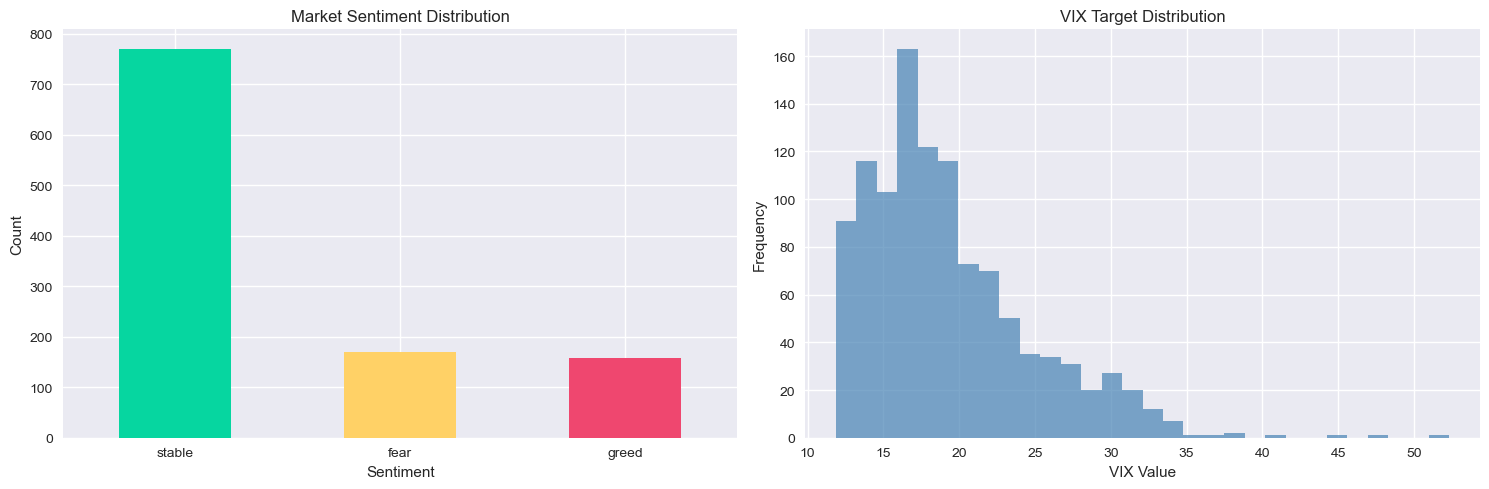

In [4]:
if FEATURES_READY:
    # Load and explore one feature set to understand the data
    sample_version = 'v1'
    sample_info = feature_summary[sample_version]
    sample_file = feature_store_dir / f"{sample_info['local_name']}.parquet"
    
    if sample_file.exists():
        sample_df = pd.read_parquet(sample_file)
        
        print(f"Sample Dataset ({sample_version}): {sample_df.shape}")
        print("\nColumns:")
        print([col for col in sample_df.columns if not col.startswith('Unnamed')])
        
        print("\nTarget Variables:")
        if 'Market_Sentiment' in sample_df.columns:
            sentiment_counts = sample_df['Market_Sentiment'].value_counts()
            print(f"Market_Sentiment: {sentiment_counts.to_dict()}")
        
        if 'VIX_Target' in sample_df.columns:
            vix_stats = sample_df['VIX_Target'].describe()
            print(f"VIX_Target: Mean={vix_stats['mean']:.2f}, Std={vix_stats['std']:.2f}")
        
        print("\nFirst 3 rows:")
        display(sample_df.head(3))
        
        # Visualize target distribution
        if 'Market_Sentiment' in sample_df.columns and 'VIX_Target' in sample_df.columns:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
            
            # Sentiment distribution
            sentiment_counts.plot(kind='bar', ax=ax1, color=['#06d6a0', '#ffd166', '#ef476f'])
            ax1.set_title('Market Sentiment Distribution')
            ax1.set_xlabel('Sentiment')
            ax1.set_ylabel('Count')
            ax1.tick_params(axis='x', rotation=0)
            
            # VIX distribution
            sample_df['VIX_Target'].hist(bins=30, ax=ax2, color='steelblue', alpha=0.7)
            ax2.set_title('VIX Target Distribution')
            ax2.set_xlabel('VIX Value')
            ax2.set_ylabel('Frequency')
            
            plt.tight_layout()
            plt.show()
    
    else:
        print(f"❌ Sample file not found: {sample_file}")
else:
    print("⚠️ Feature data not ready. Cannot show data overview.")

## Initialize AutoML Pipeline

In [5]:
# Initialize AutoML if available
if AUTOML_AVAILABLE and FEATURES_READY:
    try:
        automl = FearGreedAutoML(
            models_dir="models",
            results_dir="results"
        )
        print("✅ AutoML pipeline initialized successfully!")
        print(f"   Models directory: {automl.models_dir.resolve()}")
        print(f"   Results directory: {automl.results_dir.resolve()}")
        AUTOML_READY = True
        
        # Display available feature versions
        print("\nAvailable Feature Versions for AutoML:")
        for version, info in automl.feature_summary.items():
            print(f"   {version}: {info['num_features']} features")
            
    except Exception as e:
        print(f"❌ AutoML initialization failed: {e}")
        AUTOML_READY = False
        
else:
    print("⚠️ AutoML not available or features not ready")
    AUTOML_READY = False

Local feature summary loaded:
  v1: 20 features
  v2: 30 features
  v3: 50 features
✅ AutoML pipeline initialized successfully!
   Models directory: /Users/jason/Documents (Mac)/2025 Summer/MLOperation/fear_greed_classifier/Market-Fear-Greed-Indicator/models
   Results directory: /Users/jason/Documents (Mac)/2025 Summer/MLOperation/fear_greed_classifier/Market-Fear-Greed-Indicator/results

Available Feature Versions for AutoML:
   v1: 20 features
   v2: 30 features
   v3: 50 features


## Comprehensive AutoML Experiments

In [6]:
if AUTOML_READY:
    # Experiment configuration
    VERSIONS = ['v1', 'v2', 'v3']
    TASKS = ['classification', 'regression']
    TIME_BUDGET = 180  # 3 minutes per experiment (reduced for faster execution)
    
    print(f"Comprehensive AutoML Experiment Configuration:")
    print(f"   Versions: {VERSIONS}")
    print(f"   Tasks: {TASKS}")
    print(f"   Time budget per experiment: {TIME_BUDGET} seconds")
    print(f"   Total experiments: {len(VERSIONS) * len(TASKS)}")
    print(f"   FLAML available: {FLAML_AVAILABLE}")
    print(f"   Estimated total time: {len(VERSIONS) * len(TASKS) * TIME_BUDGET / 60:.1f} minutes")
    print()
    
    # Store all experiment results
    all_experiments = {}
    experiment_summary = []
    
    print("Starting Comprehensive AutoML Experiments")
    print("=" * 60)
    
    for version in VERSIONS:
        for task in TASKS:
            experiment_key = f"{version}_{task}"
            print(f"\n🚀 Running {experiment_key.upper()} 🚀")
            print("-" * 40)
            
            try:
                # Run the experiment
                start_time = datetime.now()
                
                results = automl.run_full_automl_pipeline(
                    version=version,
                    task_type=task,
                    time_budget=TIME_BUDGET
                )
                
                end_time = datetime.now()
                duration = (end_time - start_time).total_seconds()
                
                # Store results
                all_experiments[experiment_key] = results
                
                # Extract key metrics for summary
                best_source = results['best_source']
                n_features = results['data_info']['n_features']
                train_samples = results['data_info']['train_samples']
                test_samples = results['data_info']['test_samples']
                
                # Get best performance metric
                if task == 'classification':
                    test_metric = results['test_results']['test_accuracy']
                    metric_name = 'Accuracy'
                else:
                    test_metric = results['test_results']['test_r2']
                    metric_name = 'R²'
                
                experiment_summary.append({
                    'version': version,
                    'task': task,
                    'best_model': best_source,
                    'n_features': n_features,
                    'train_samples': train_samples,
                    'test_samples': test_samples,
                    'test_metric': test_metric,
                    'metric_name': metric_name,
                    'duration_sec': duration,
                    'flaml_available': FLAML_AVAILABLE
                })
                
                print(f"✅ SUCCESS: {experiment_key}")
                print(f"   Best Model: {best_source}")
                print(f"   Test {metric_name}: {test_metric:.4f}")
                print(f"   Duration: {duration:.1f}s")
                
            except Exception as e:
                print(f"❌ FAILED: {experiment_key}")
                print(f"   Error: {str(e)}")
                
                # Add failed experiment to summary
                experiment_summary.append({
                    'version': version,
                    'task': task,
                    'best_model': 'FAILED',
                    'n_features': 0,
                    'train_samples': 0,
                    'test_samples': 0,
                    'test_metric': 0.0,
                    'metric_name': 'N/A',
                    'duration_sec': 0.0,
                    'flaml_available': False
                })
    
    print("\n🎉 All AutoML experiments completed!")
    
else:
    print("⚠️ AutoML experiments skipped - AutoML not ready")
    all_experiments = {}
    experiment_summary = []

Comprehensive AutoML Experiment Configuration:
   Versions: ['v1', 'v2', 'v3']
   Tasks: ['classification', 'regression']
   Time budget per experiment: 180 seconds
   Total experiments: 6
   FLAML available: True
   Estimated total time: 18.0 minutes

Starting Comprehensive AutoML Experiments

🚀 Running V1_CLASSIFICATION 🚀
----------------------------------------
Running Full AutoML Pipeline
   Version: v1
   Task: classification
Preparing data for classification task (version: v1)...
Loaded dataset: (1098, 23)
Data prepared:
   - Train: (657, 20)
   - Validation: (220, 20)
   - Test: (220, 20)
   - Features: 20
Running sklearn AutoML for classification...
   - Models: ['random_forest', 'logistic_regression', 'mlp', 'svm']
   - Time budget: 180s
   Training random_forest...
     SUCCESS: random_forest
   Training logistic_regression...
     SUCCESS: logistic_regression
   Training mlp...
     SUCCESS: mlp
   Training svm...
     SUCCESS: svm
Running FLAML AutoML for classification...


## Results Summary and Analysis

AutoML Experiment Results Summary


,version,task,best_model,n_features,train_samples,test_samples,test_metric,metric_name,duration_sec,flaml_available
0,v1,classification,sklearn,20,657,220,0.645455,Accuracy,182.026112,True
1,v1,regression,sklearn,20,657,220,0.205882,R²,191.411232,True
2,v2,classification,flaml,30,657,220,0.863636,Accuracy,183.036200,True
3,v2,regression,sklearn,30,657,220,0.294684,R²,184.207019,True
4,v3,classification,sklearn,50,657,220,0.913636,Accuracy,183.888275,True
5,v3,regression,sklearn,50,657,220,0.390695,R²,188.896681,True



Summary saved to: /Users/jason/Documents (Mac)/2025 Summer/MLOperation/fear_greed_classifier/Market-Fear-Greed-Indicator/results/integrated_automl_summary_20250820_193543.csv

Successful experiments: 6/6


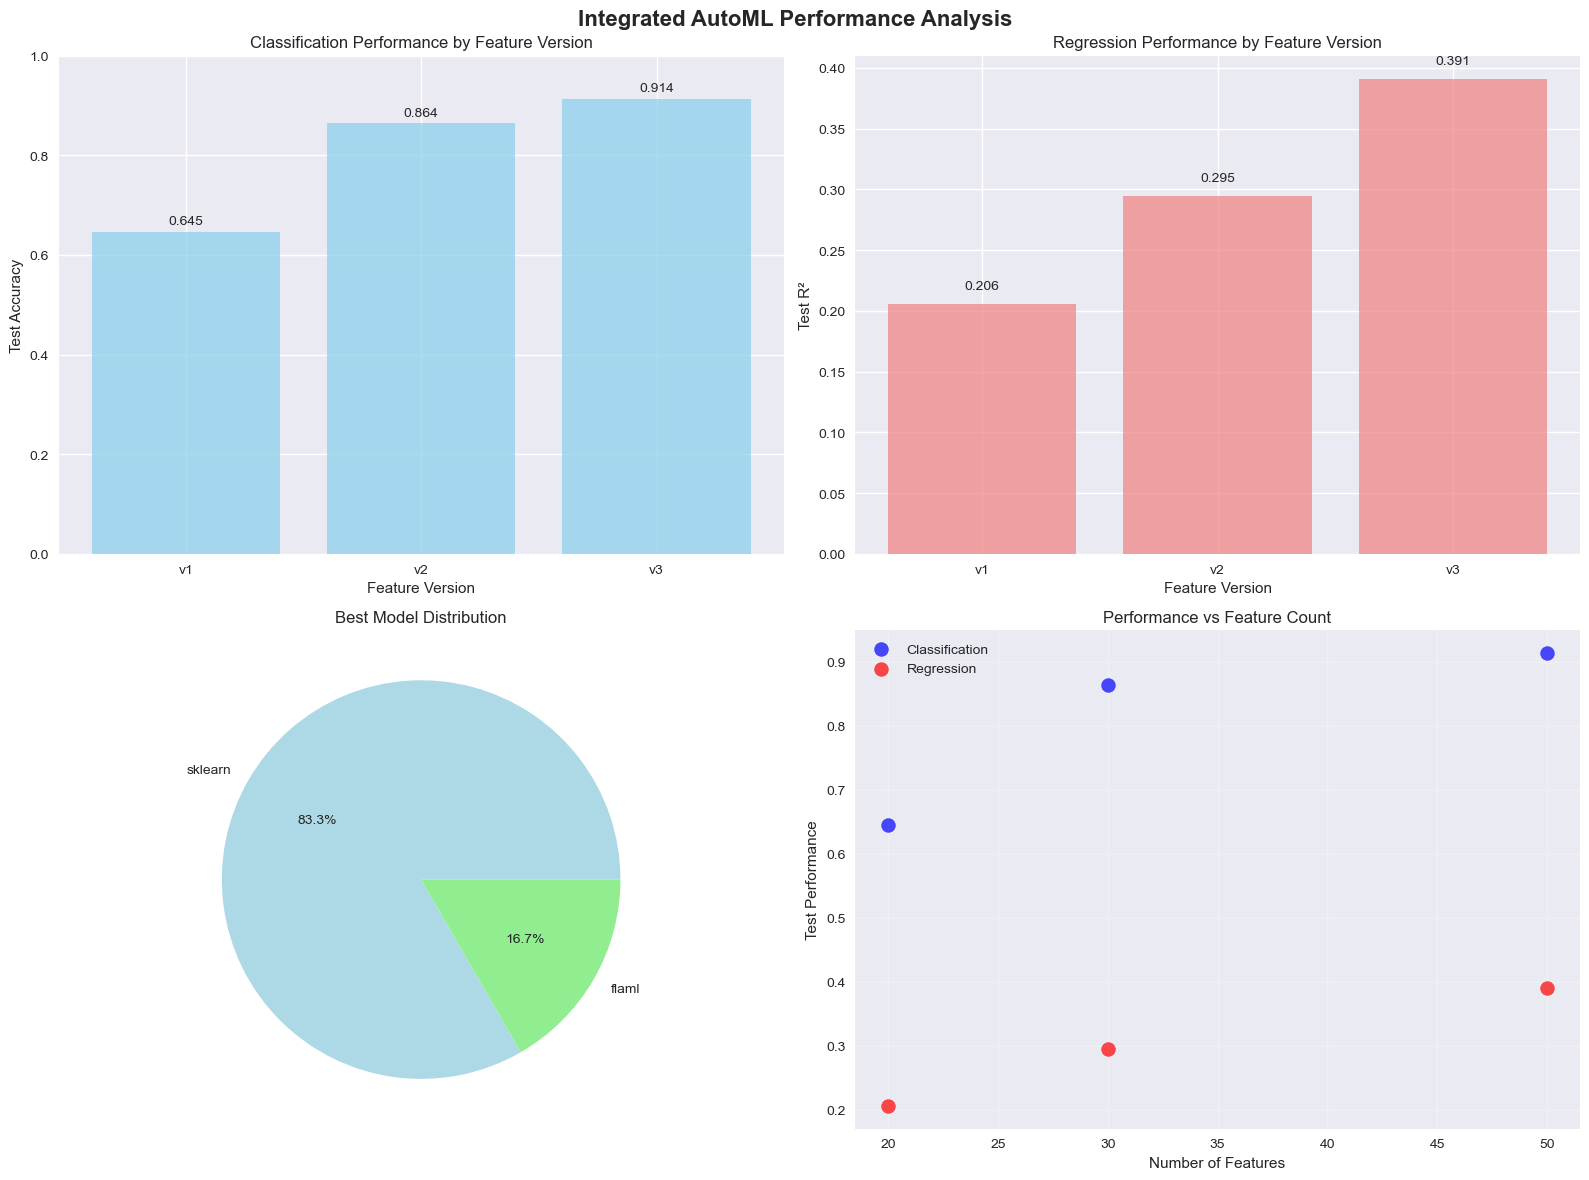

Performance analysis plot saved to: /Users/jason/Documents (Mac)/2025 Summer/MLOperation/fear_greed_classifier/Market-Fear-Greed-Indicator/results/integrated_automl_analysis_20250820_193543.png


In [7]:
if experiment_summary:
    # Create summary DataFrame
    summary_df = pd.DataFrame(experiment_summary)
    
    print("AutoML Experiment Results Summary")
    print("=" * 50)
    display(summary_df)
    
    # Save summary
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    summary_file = results_dir / f"integrated_automl_summary_{timestamp}.csv"
    summary_df.to_csv(summary_file, index=False)
    print(f"\nSummary saved to: {summary_file}")
    
    # Filter successful experiments
    success_df = summary_df[summary_df['best_model'] != 'FAILED'].copy()
    
    if not success_df.empty:
        print(f"\nSuccessful experiments: {len(success_df)}/{len(summary_df)}")
        
        # Performance analysis
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Integrated AutoML Performance Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Test Performance by Version and Task
        classification_df = success_df[success_df['task'] == 'classification']
        regression_df = success_df[success_df['task'] == 'regression']
        
        if not classification_df.empty:
            axes[0,0].bar(classification_df['version'], classification_df['test_metric'], 
                          alpha=0.7, color='skyblue', label='Classification Accuracy')
            axes[0,0].set_title('Classification Performance by Feature Version')
            axes[0,0].set_ylabel('Test Accuracy')
            axes[0,0].set_xlabel('Feature Version')
            axes[0,0].set_ylim(0, 1)
            
            # Add value labels on bars
            for i, v in enumerate(classification_df['test_metric']):
                axes[0,0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        if not regression_df.empty:
            axes[0,1].bar(regression_df['version'], regression_df['test_metric'], 
                          alpha=0.7, color='lightcoral', label='Regression R²')
            axes[0,1].set_title('Regression Performance by Feature Version')
            axes[0,1].set_ylabel('Test R²')
            axes[0,1].set_xlabel('Feature Version')
            
            # Add value labels on bars
            for i, v in enumerate(regression_df['test_metric']):
                axes[0,1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
        
        # Plot 3: Model Selection Distribution
        model_counts = success_df['best_model'].value_counts()
        if not model_counts.empty:
            colors = ['lightblue', 'lightgreen', 'orange', 'pink']
            axes[1,0].pie(model_counts.values, labels=model_counts.index, autopct='%1.1f%%',
                          colors=colors[:len(model_counts)])
            axes[1,0].set_title('Best Model Distribution')
        
        # Plot 4: Feature Count vs Performance
        if not success_df.empty:
            class_scatter = success_df[success_df['task'] == 'classification']
            reg_scatter = success_df[success_df['task'] == 'regression']
            
            if not class_scatter.empty:
                axes[1,1].scatter(class_scatter['n_features'], class_scatter['test_metric'], 
                                 alpha=0.7, s=100, color='blue', label='Classification')
            
            if not reg_scatter.empty:
                axes[1,1].scatter(reg_scatter['n_features'], reg_scatter['test_metric'], 
                                 alpha=0.7, s=100, color='red', label='Regression')
            
            axes[1,1].set_xlabel('Number of Features')
            axes[1,1].set_ylabel('Test Performance')
            axes[1,1].set_title('Performance vs Feature Count')
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Save the plot
        plot_file = results_dir / f"integrated_automl_analysis_{timestamp}.png"
        fig.savefig(plot_file, dpi=300, bbox_inches='tight')
        print(f"Performance analysis plot saved to: {plot_file}")
        
    else:
        print("⚠️ No successful experiments to analyze")
        
else:
    print("⚠️ No experiment results to display")

## Best Models Summary and Recommendations

In [8]:
if experiment_summary and len(success_df) > 0:
    print("📊 BEST MODELS SUMMARY AND RECOMMENDATIONS")
    print("=" * 60)
    
    # Best classification model
    classification_results = success_df[success_df['task'] == 'classification']
    if not classification_results.empty:
        best_classification = classification_results.loc[classification_results['test_metric'].idxmax()]
        print(f"🏆 BEST CLASSIFICATION MODEL:")
        print(f"   Version: {best_classification['version']}")
        print(f"   Model: {best_classification['best_model']}")
        print(f"   Test Accuracy: {best_classification['test_metric']:.4f}")
        print(f"   Features: {best_classification['n_features']}")
        print()
    
    # Best regression model
    regression_results = success_df[success_df['task'] == 'regression']
    if not regression_results.empty:
        best_regression = regression_results.loc[regression_results['test_metric'].idxmax()]
        print(f"🏆 BEST REGRESSION MODEL:")
        print(f"   Version: {best_regression['version']}")
        print(f"   Model: {best_regression['best_model']}")
        print(f"   Test R²: {best_regression['test_metric']:.4f}")
        print(f"   Features: {best_regression['n_features']}")
        print()
    
    # Performance by feature version
    print("📈 PERFORMANCE BY FEATURE VERSION:")
    VERSIONS = ['v1', 'v2', 'v3']
    for version in VERSIONS:
        version_results = success_df[success_df['version'] == version]
        if not version_results.empty:
            print(f"\n{version.upper()}:")
            for _, row in version_results.iterrows():
                print(f"  {row['task']}: {row['test_metric']:.4f} ({row['metric_name']}) - {row['best_model']}")
    
    # Model preference analysis
    print(f"\n🤖 MODEL PREFERENCE ANALYSIS:")
    model_preference = success_df['best_model'].value_counts()
    for model, count in model_preference.items():
        percentage = (count / len(success_df)) * 100
        print(f"   {model}: {count}/{len(success_df)} experiments ({percentage:.1f}%)")
    
    print(f"\n💡 RECOMMENDATIONS FOR PRODUCTION:")
    
    # Best overall model recommendation
    if len(classification_results) > 0:
        best_class = classification_results.loc[classification_results['test_metric'].idxmax()]
        print(f"   📍 For classification: Use {best_class['version']} features with {best_class['best_model']} model")
    
    if len(regression_results) > 0:
        best_reg = regression_results.loc[regression_results['test_metric'].idxmax()]
        print(f"   📍 For regression: Use {best_reg['version']} features with {best_reg['best_model']} model")
    
    # FLAML availability
    flaml_success = success_df['flaml_available'].any()
    if flaml_success:
        flaml_wins = len(success_df[success_df['best_model'] == 'flaml'])
        print(f"   📍 FLAML won {flaml_wins} experiments - excellent for production AutoML")
    else:
        print(f"   📍 Consider installing FLAML (pip install flaml) for enhanced AutoML")
    
    # Production deployment
    model_files = list(models_dir.glob('*.joblib'))
    print(f"   📍 {len(model_files)} models saved in 'models/' directory for deployment")
    print(f"   📍 All results saved in 'results/' directory for analysis")
    
    print(f"\n🚀 NEXT STEPS FOR MLOPs PIPELINE:")
    print(f"   • Deploy best models to production environment")
    print(f"   • Set up model monitoring and drift detection")
    print(f"   • Implement automated retraining pipeline")
    print(f"   • Create A/B testing framework for model comparison")
    print(f"   • Add model explainability tools for stakeholder understanding")
    
else:
    print("⚠️ No successful experiments to provide recommendations")

📊 BEST MODELS SUMMARY AND RECOMMENDATIONS
🏆 BEST CLASSIFICATION MODEL:
   Version: v3
   Model: sklearn
   Test Accuracy: 0.9136
   Features: 50

🏆 BEST REGRESSION MODEL:
   Version: v3
   Model: sklearn
   Test R²: 0.3907
   Features: 50

📈 PERFORMANCE BY FEATURE VERSION:

V1:
  classification: 0.6455 (Accuracy) - sklearn
  regression: 0.2059 (R²) - sklearn

V2:
  classification: 0.8636 (Accuracy) - flaml
  regression: 0.2947 (R²) - sklearn

V3:
  classification: 0.9136 (Accuracy) - sklearn
  regression: 0.3907 (R²) - sklearn

🤖 MODEL PREFERENCE ANALYSIS:
   sklearn: 5/6 experiments (83.3%)
   flaml: 1/6 experiments (16.7%)

💡 RECOMMENDATIONS FOR PRODUCTION:
   📍 For classification: Use v3 features with sklearn model
   📍 For regression: Use v3 features with sklearn model
   📍 FLAML won 1 experiments - excellent for production AutoML
   📍 13 models saved in 'models/' directory for deployment
   📍 All results saved in 'results/' directory for analysis

🚀 NEXT STEPS FOR MLOPs PIPELINE:


## Feature Importance Analysis (for available models)

📊 FEATURE IMPORTANCE ANALYSIS

📈 best_v3_regression_20250820_193543.joblib (v3 - regression - sklearn)
----------------------------------------
Top 10 Most Important Features (Tree-based):
   1. SPY_Volatility: 0.2389
   2. ratio_SPY_Price_over_QQQ_Price: 0.2071
   3. QQQ_Volatility: 0.0987
   4. ratio_SPY_Price_over_HYG_Price: 0.0977
   5. QQQ_Volume: 0.0620
   6. SPY_Volume: 0.0543
   7. HYG_Price_ma30: 0.0294
   8. GLD_Price_ma30: 0.0235
   9. ratio_QQQ_Price_over_TLT_Price: 0.0219
  10. BAMLH0A0HYM2: 0.0188


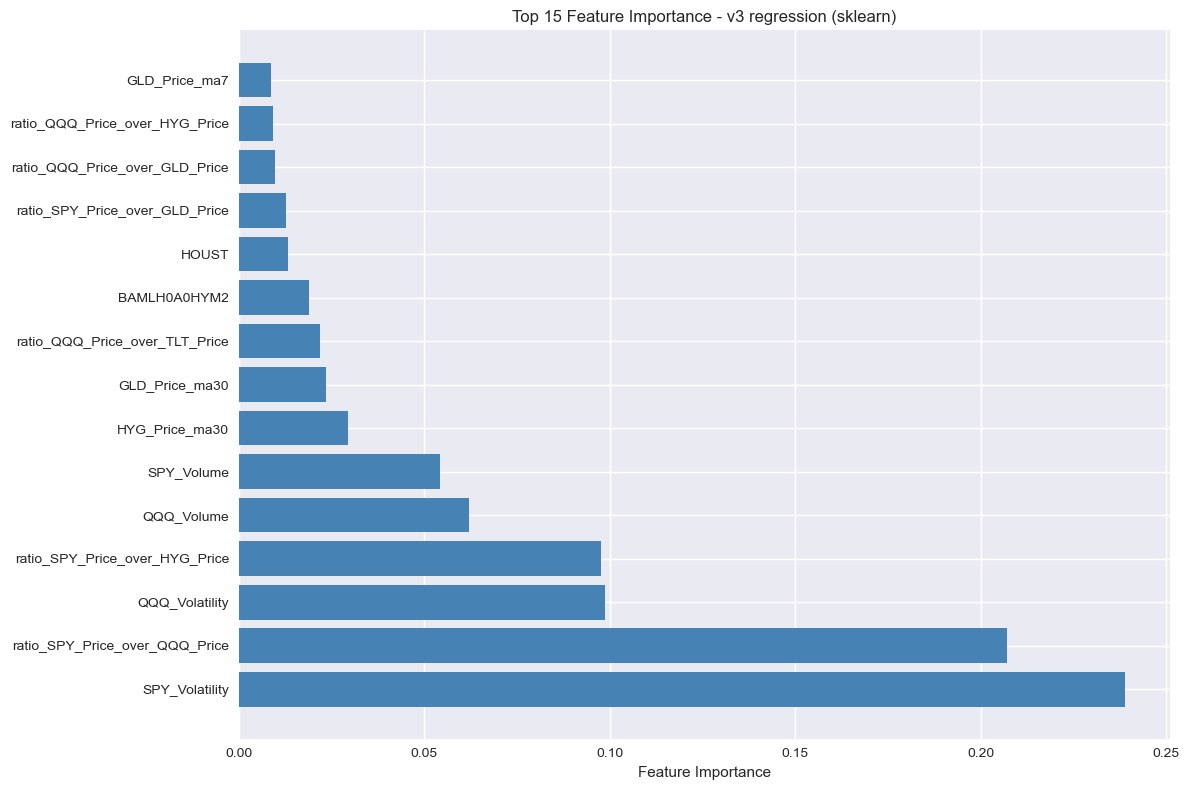

   📊 Feature importance plot saved: feature_importance_v3_regression_sklearn.png

📈 best_v3_classification_20250820_193234.joblib (v3 - classification - sklearn)
----------------------------------------
  ⚠️ Feature importance not available for this model type
     Model type: LogisticRegression
     Has feature_importances_: False
     Has coef_: True

📈 best_v2_regression_20250820_192930.joblib (v2 - regression - sklearn)
----------------------------------------
Top 10 Most Important Features (Tree-based):
   1. SPY_Volatility: 0.3067
   2. QQQ_Volatility: 0.2192
   3. QQQ_Volume: 0.0922
   4. SPY_Volume: 0.0735
   5. GLD_Price_ma30: 0.0637
   6. CPIAUCSL: 0.0603
   7. BAMLH0A0HYM2: 0.0351
   8. TLT_Price_ma30: 0.0151
   9. GLD_Volatility: 0.0127
  10. SPY_Price_ma7: 0.0117


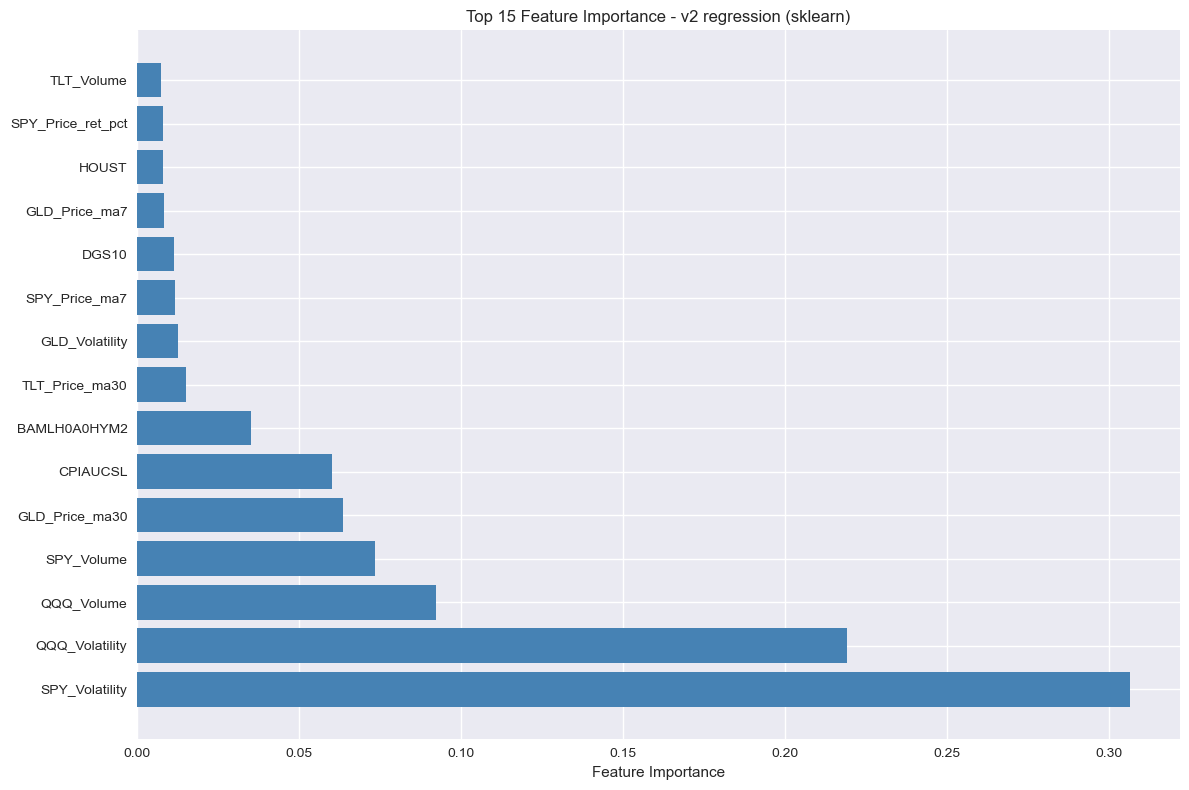

   📊 Feature importance plot saved: feature_importance_v2_regression_sklearn.png


In [9]:
# Load and analyze feature importance for the available models
model_files = list(models_dir.glob('*.joblib'))

if model_files:
    print("📊 FEATURE IMPORTANCE ANALYSIS")
    print("=" * 50)
    
    # Get the latest models (top 3)
    latest_models = sorted(model_files, key=lambda x: x.stat().st_mtime, reverse=True)[:3]
    
    for model_file in latest_models:
        try:
            # Load model
            model_data = joblib.load(model_file)
            model = model_data['model']
            feature_names = model_data['feature_names']
            version = model_data.get('version', 'unknown')
            task_type = model_data.get('task_type', 'unknown')
            best_source = model_data.get('best_source', 'unknown')
            
            print(f"\n📈 {model_file.name} ({version} - {task_type} - {best_source})")
            print("-" * 40)
            
            # Extract feature importance if available
            feature_importance = None
            importance_type = "Unknown"
            
            # Handle FLAML models
            if best_source == 'flaml' and hasattr(model, 'model'):
                actual_model = model.model
                if hasattr(actual_model, 'feature_importances_'):
                    feature_importance = actual_model.feature_importances_
                    importance_type = "Tree-based"
                elif hasattr(actual_model, 'coef_'):
                    feature_importance = np.abs(actual_model.coef_.flatten() if len(actual_model.coef_.shape) > 1 else actual_model.coef_)
                    importance_type = "Linear coefficients (absolute)"
            # Handle sklearn models
            elif hasattr(model, 'feature_importances_'):
                feature_importance = model.feature_importances_
                importance_type = "Tree-based"
            elif hasattr(model, 'coef_'):
                feature_importance = np.abs(model.coef_.flatten() if len(model.coef_.shape) > 1 else model.coef_)
                importance_type = "Linear coefficients (absolute)"
            
            if feature_importance is not None and len(feature_importance) == len(feature_names):
                # Create feature importance DataFrame
                importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': feature_importance
                }).sort_values('importance', ascending=False)
                
                # Show top 10 features
                print(f"Top 10 Most Important Features ({importance_type}):")
                for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
                    print(f"  {i:2d}. {row['feature']}: {row['importance']:.4f}")
                
                # Plot feature importance for reasonable number of features
                if len(feature_names) <= 50:
                    plt.figure(figsize=(12, 8))
                    top_features = importance_df.head(15)  # Top 15 features
                    
                    plt.barh(range(len(top_features)), top_features['importance'][::-1], color='steelblue')
                    plt.yticks(range(len(top_features)), top_features['feature'][::-1])
                    plt.xlabel('Feature Importance')
                    plt.title(f'Top 15 Feature Importance - {version} {task_type} ({best_source})')
                    plt.gca().invert_yaxis()
                    plt.tight_layout()
                    
                    # Save plot
                    plot_name = f"feature_importance_{version}_{task_type}_{best_source}.png"
                    plt.savefig(results_dir / plot_name, dpi=300, bbox_inches='tight')
                    plt.show()
                    
                    print(f"   📊 Feature importance plot saved: {plot_name}")
            else:
                print("  ⚠️ Feature importance not available for this model type")
                print(f"     Model type: {type(model).__name__}")
                print(f"     Has feature_importances_: {hasattr(model, 'feature_importances_')}")
                print(f"     Has coef_: {hasattr(model, 'coef_')}")
                
        except Exception as e:
            print(f"  ❌ Error loading {model_file.name}: {str(e)}")
            
else:
    print("⚠️ No model files found in the models directory for feature importance analysis")

## Save Complete Experiment Report

In [10]:
# Save complete integrated experiment report
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

if experiment_summary:
    # Create comprehensive report
    report_data = {
        'experiment_info': {
            'timestamp': timestamp,
            'notebook_type': 'Integrated Fear & Greed ML Pipeline',
            'feature_store_available': FEATURE_STORE_AVAILABLE,
            'automl_available': AUTOML_AVAILABLE,
            'flaml_available': FLAML_AVAILABLE
        },
        'configuration': {
            'versions': ['v1', 'v2', 'v3'],
            'tasks': ['classification', 'regression'],
            'time_budget_per_experiment': TIME_BUDGET if 'TIME_BUDGET' in locals() else 180
        },
        'summary_statistics': summary_df.to_dict('records') if 'summary_df' in locals() else [],
        'detailed_results': all_experiments
    }
    
    # Add feature information if available
    if 'feature_summary' in locals():
        report_data['feature_info'] = feature_summary
    
    report_file = results_dir / f"integrated_ml_pipeline_report_{timestamp}.json"
    with open(report_file, 'w') as f:
        json.dump(report_data, f, indent=2, default=str)
    
    # Summary of all generated files
    print("📄 INTEGRATED ML PIPELINE - COMPLETE REPORT")
    print("=" * 60)
    print(f"Report timestamp: {timestamp}")
    print(f"Complete report saved: {report_file}")
    
    if 'summary_file' in locals():
        print(f"Summary CSV: {summary_file}")
    
    # List model files
    model_files = list(models_dir.glob('*.joblib'))
    if model_files:
        print(f"\n🤖 SAVED MODELS ({len(model_files)} files):")
        for model_file in sorted(model_files, key=lambda x: x.stat().st_mtime, reverse=True)[:5]:
            print(f"   • {model_file.name}")
        if len(model_files) > 5:
            print(f"   ... and {len(model_files) - 5} more")
    
    # List result files
    result_files = list(results_dir.glob('*.json')) + list(results_dir.glob('*.csv')) + list(results_dir.glob('*.png'))
    if result_files:
        print(f"\n📊 SAVED RESULTS ({len(result_files)} files):")
        for result_file in sorted(result_files, key=lambda x: x.stat().st_mtime, reverse=True)[:7]:
            print(f"   • {result_file.name}")
        if len(result_files) > 7:
            print(f"   ... and {len(result_files) - 7} more")
    
    print(f"\n🎉 INTEGRATED ML PIPELINE COMPLETED SUCCESSFULLY! 🎉")
    
    # Final recommendations
    if 'success_df' in locals() and len(success_df) > 0:
        print(f"\n✅ SUCCESS SUMMARY:")
        print(f"   • Successful experiments: {len(success_df)}/{len(summary_df)}")
        print(f"   • Feature versions tested: {success_df['version'].nunique()}")
        print(f"   • Tasks completed: {success_df['task'].nunique()}")
        print(f"   • Best classification accuracy: {success_df[success_df['task'] == 'classification']['test_metric'].max():.4f}")
        if len(success_df[success_df['task'] == 'regression']) > 0:
            print(f"   • Best regression R²: {success_df[success_df['task'] == 'regression']['test_metric'].max():.4f}")
        print(f"   • Ready for production deployment!")
        
else:
    print("⚠️ No experiments were completed - check feature store and AutoML setup")
    
    # Still save basic info
    basic_report = {
        'timestamp': timestamp,
        'status': 'incomplete',
        'feature_store_available': FEATURE_STORE_AVAILABLE,
        'automl_available': AUTOML_AVAILABLE,
        'features_ready': FEATURES_READY if 'FEATURES_READY' in locals() else False,
        'automl_ready': AUTOML_READY if 'AUTOML_READY' in locals() else False
    }
    
    report_file = results_dir / f"integrated_ml_pipeline_incomplete_{timestamp}.json"
    with open(report_file, 'w') as f:
        json.dump(basic_report, f, indent=2)
    
    print(f"Basic report saved: {report_file}")

📄 INTEGRATED ML PIPELINE - COMPLETE REPORT
Report timestamp: 20250820_193545
Complete report saved: /Users/jason/Documents (Mac)/2025 Summer/MLOperation/fear_greed_classifier/Market-Fear-Greed-Indicator/results/integrated_ml_pipeline_report_20250820_193545.json
Summary CSV: /Users/jason/Documents (Mac)/2025 Summer/MLOperation/fear_greed_classifier/Market-Fear-Greed-Indicator/results/integrated_automl_summary_20250820_193543.csv

🤖 SAVED MODELS (13 files):
   • best_v3_regression_20250820_193543.joblib
   • best_v3_classification_20250820_193234.joblib
   • best_v2_regression_20250820_192930.joblib
   • best_v2_classification_20250820_192626.joblib
   • best_v1_regression_20250820_192323.joblib
   ... and 8 more

📊 SAVED RESULTS (22 files):
   • integrated_ml_pipeline_report_20250820_193545.json
   • feature_importance_v2_regression_sklearn.png
   • feature_importance_v3_regression_sklearn.png
   • integrated_automl_analysis_20250820_193543.png
   • integrated_automl_summary_20250820_19